In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing as HWES
from scipy import stats
import statsmodels.api as sm

In [2]:
df = pd.read_csv("nasa1.csv", header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df.index.freq = 'D'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5053 entries, 2011-01-01 to 2024-10-31
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Suhu         5050 non-null   float64
 1   Kelembaban   5050 non-null   float64
 2   Curah_Hujan  5050 non-null   float64
dtypes: float64(3)
memory usage: 157.9 KB


In [4]:
df.describe()
#NASA Sebelum Imputasi

,Suhu,Kelembaban,Curah_Hujan
count,5050.000000,5050.000000,5050.000000
mean,26.990713,79.178727,6.194432
std,0.826380,4.462853,10.158024
min,24.370000,63.690000,0.000000
25%,26.410000,76.250000,0.740000
50%,26.950000,79.250000,2.665000
75%,27.550000,82.250000,7.060000
max,30.070000,92.000000,149.120000


In [5]:
# Melihat jumlah nilai null di setiap kolom
null_counts = df.isnull().sum()
print(null_counts)

Suhu           3
Kelembaban     3
Curah_Hujan    3
dtype: int64


In [6]:
# Mengisi data kosong dengan mean dari masing-masing kolom
cols_to_fill = ['Curah_Hujan', 'Kelembaban', 'Suhu']  # Kolom target

for col in cols_to_fill:
    mean_value = df[col].mean()  # Menghitung mean dari kolom
    df[col] = df[col].fillna(mean_value)  # Mengisi nilai kosong dengan mean

print(df)

             Suhu  Kelembaban  Curah_Hujan
Tanggal                                   
2011-01-01  26.02       81.94        10.95
2011-01-02  25.93       84.81         6.97
2011-01-03  26.10       80.88         4.85
2011-01-04  25.73       80.56         9.94
2011-01-05  25.60       84.00         5.04
...           ...         ...          ...
2024-10-27  27.44       79.94         2.33
2024-10-28  27.52       79.69         1.27
2024-10-29  27.20       80.50         1.39
2024-10-30  27.35       79.31         1.97
2024-10-31  27.82       75.31         0.41

[5053 rows x 3 columns]


In [7]:
df.describe()
#Nasa Setelah Imputasi

,Suhu,Kelembaban,Curah_Hujan
count,5053.000000,5053.000000,5053.000000
mean,26.990713,79.178727,6.194432
std,0.826134,4.461528,10.155008
min,24.370000,63.690000,0.000000
25%,26.410000,76.250000,0.740000
50%,26.950000,79.250000,2.670000
75%,27.550000,82.250000,7.060000
max,30.070000,92.000000,149.120000


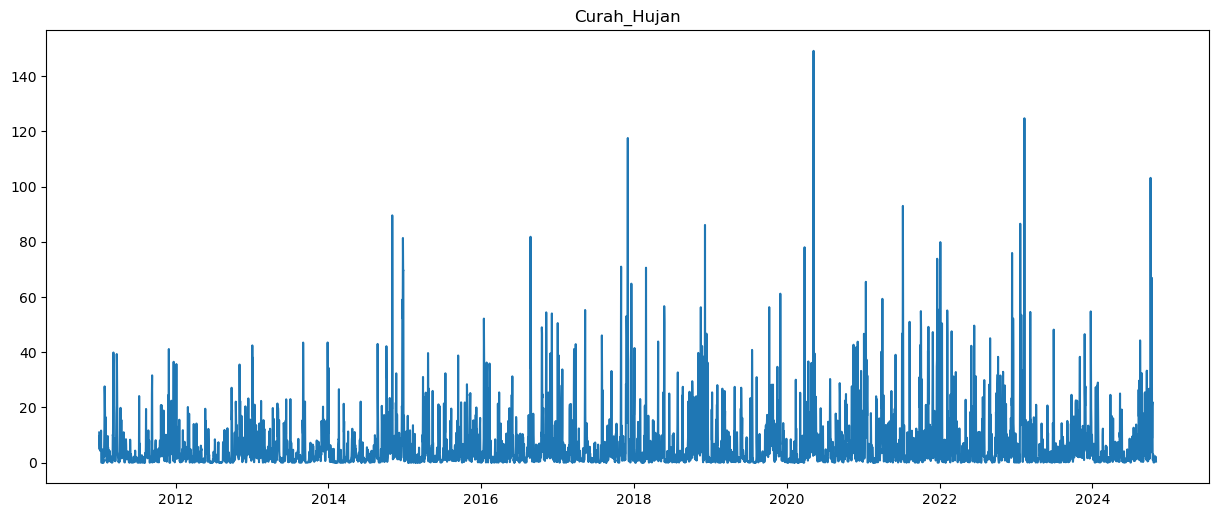

In [8]:
plt.figure(figsize=(15, 6), dpi=100)
plt.title('Curah_Hujan')
plt.plot(df['Curah_Hujan'])

In [9]:
data = df.drop(columns=['Kelembaban', 'Suhu'])

In [57]:
# Menghitung Q1 (kuartil pertama) dan Q3 (kuartil ketiga)
Q1 = df['Curah_Hujan'].quantile(0.25)
Q3 = df['Curah_Hujan'].quantile(0.75)

# Menghitung IQR (Interquartile Range)
IQR = Q3 - Q1

# Menentukan batas bawah dan batas atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifikasi data outlier
outliers = df[(df['Curah_Hujan'] < lower_bound) | (df['Curah_Hujan'] > upper_bound)]

# Menampilkan jumlah data outlier
print(f"Jumlah data outlier: {outliers.shape[0]}")

# Menampilkan data outlier
print(outliers)
print("Nilai outliers:", min(outliers['Curah_Hujan']))

Jumlah data outlier: 427
            Suhu  Kelembaban  Curah_Hujan  Curah_Hujan_Transformed
Tanggal                                                           
2011-01-01  25.2        89.0         22.0                 0.829748
2011-01-27  25.4        90.0         47.0                 2.398324
2011-03-09  25.1        89.0         45.0                 2.272838
2011-03-10  25.9        86.0        101.0                 5.786446
2011-03-17  25.6        88.0         26.0                 1.080720
...          ...         ...          ...                      ...
2024-08-10  26.7        85.0        134.9                 7.913434
2024-08-23  27.2        81.0         29.6                 1.306595
2024-09-17  24.4        92.0         37.5                 1.802265
2024-09-18  28.7        67.0         69.4                 3.803767
2024-09-29  26.5        88.0         24.9                 1.011703

[427 rows x 4 columns]
Nilai outliers: 22.0


In [842]:
Q1 = df['Curah_Hujan'].quantile(0.25)
Q3 = df['Curah_Hujan'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (df['Curah_Hujan'] < (Q1 - 1.5 * IQR)) | (df['Curah_Hujan'] > (Q3 + 1.5 * IQR))
df.loc[outlier_mask, 'Curah_Hujan'] = df['Curah_Hujan'].median()  # atau interpolasi

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Curah_Hujan_Transformed'] = scaler.fit_transform(df[['Curah_Hujan']]) # Penambahan offset, sesuaikan nilai

In [58]:
df['Curah_Hujan_Transformed'] = df['Curah_Hujan'].rolling(window=7, center=True).mean()
df['Curah_Hujan_Transformed'] = df['Curah_Hujan_Transformed'].fillna(method='bfill').fillna(method='ffill')
# Cek hasil smoothing
print(df['Curah_Hujan_Transformed'])

Tanggal
2011-01-01    9.285714
2011-01-02    9.285714
2011-01-03    9.285714
2011-01-04    9.285714
2011-01-05    6.428571
                ...   
2024-10-27    0.642857
2024-10-28    0.642857
2024-10-29    0.642857
2024-10-30    0.642857
2024-10-31    0.642857
Freq: D, Name: Curah_Hujan_Transformed, Length: 5053, dtype: float64


In [99]:
# Winsorizing (membatasi nilai dalam rentang persentil tertentu)
lower_percentile = df['Curah_Hujan'].quantile(0.05)
upper_percentile = df['Curah_Hujan'].quantile(0.95)
df['Curah_Hujan_Transformed'] = df['Curah_Hujan'].clip(lower=lower_percentile, upper=upper_percentile)

In [742]:
# Hitung rata-rata dari kolom 'curah_hujan'
mean_value = df['Curah_Hujan'].mean()

# Ganti nilai yang lebih besar dari 50 dengan rata-rata
df.loc[df['Curah_Hujan'] > 19.3, 'Curah_Hujan'] = mean_value

# Tampilkan hasil
print(df)

            Curah_Hujan
Tanggal                
2021-01-01    18.920000
2021-01-02    11.790000
2021-01-03     4.740000
2021-01-04     7.119678
2021-01-05     7.119678
...                 ...
2024-07-27     7.330000
2024-07-28    13.820000
2024-07-29     5.290000
2024-07-30     1.230000
2024-07-31     3.190000

[1308 rows x 1 columns]


In [9]:
df['Curah_Hujan_Transformed'] = np.log(df['Curah_Hujan']+10)

In [10]:
df

,Suhu,Kelembaban,Curah_Hujan,Curah_Hujan_Transformed
Tanggal,,,,
2011-01-01,26.02,81.94,10.95,3.042139
2011-01-02,25.93,84.81,6.97,2.831447
2011-01-03,26.10,80.88,4.85,2.698000
2011-01-04,25.73,80.56,9.94,2.992728
2011-01-05,25.60,84.00,5.04,2.710713
...,...,...,...,...
2024-10-27,27.44,79.94,2.33,2.512035
2024-10-28,27.52,79.69,1.27,2.422144
2024-10-29,27.20,80.50,1.39,2.432736


In [71]:
import pandas as pd

# Misalkan df adalah DataFrame yang berisi data curah hujan
df['Curah_Hujan_Transformed'] = (df['Curah_Hujan'] - df['Curah_Hujan'].min()) / (df['Curah_Hujan'].max() - df['Curah_Hujan'].min())

In [12]:
# Transformasi logaritmik
df['Curah_Hujan_Transformed'] = np.log(df['Curah_Hujan'] + 10)

In [279]:
# Transformasi logaritmik
df['Curah_Hujan_Transformed'] = np.log1p(df['Curah_Hujan'] + 10)

In [235]:
from scipy.stats.mstats import winsorize
df['Curah_Hujan_Transformed'] = winsorize(df['Curah_Hujan'], limits=[0.05, 0.05])

In [226]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
df['Curah_Hujan_Transformed'] = pt.fit_transform(df[['Curah_Hujan']])

In [133]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df['Curah_Hujan_Transformed'] = scaler.fit_transform(df[['Curah_Hujan']])

In [214]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Curah_Hujan_Transformed'] = scaler.fit_transform(df[['Curah_Hujan']])

In [918]:
from scipy import stats
df['Curah_Hujan_Transformed'] = np.sqrt(df['Curah_Hujan'])

In [240]:
df

,Suhu,Kelembaban,Curah_Hujan,Curah_Hujan_Transformed,curah_hujan_trans
Tanggal,,,,,
2011-01-01,25.2,89.0,22.0,22.0,3.740797
2011-01-02,26.5,85.0,5.0,5.0,1.775005
2011-01-03,26.8,86.0,5.0,5.0,1.775005
2011-01-04,25.9,89.0,16.0,16.0,3.288362
2011-01-05,26.5,85.0,0.0,0.0,-6.753782
...,...,...,...,...,...
2024-10-27,27.5,75.0,0.0,0.0,-6.753782
2024-10-28,28.8,75.0,4.5,4.5,1.648051
2024-10-29,28.3,75.0,0.0,0.0,-6.753782


In [254]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def find_best_c(data, c_values, seasonal_periods):
    tscv = TimeSeriesSplit(n_splits=5)
    best_c = None
    best_rmse = float('inf')

    for c in c_values:
        transformed_data = np.log1p(data + c)
        rmses = []

        for train_idx, test_idx in tscv.split(transformed_data):
            train, test = transformed_data[train_idx], transformed_data[test_idx]

            # Buat model Holt-Winters untuk data training
            model = ExponentialSmoothing(
                train,
                seasonal='additive',  # Atau 'multiplicative' jika cocok
                seasonal_periods=seasonal_periods,
                trend='additive'
            ).fit()

            # Prediksi pada data test
            preds = model.forecast(len(test))
            rmses.append(mean_squared_error(test, preds, squared=False))

        # Evaluasi rata-rata RMSE untuk nilai C ini
        avg_rmse = np.mean(rmses)
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_c = c

    return best_c, best_rmse

# Contoh pemanggilan
c_values = np.linspace(0.1, 10, 50)  # Rentang nilai C
seasonal_periods = 365  # Sesuaikan dengan pola musiman data
best_c, best_rmse = find_best_c(data['Curah_Hujan'].values, c_values, seasonal_periods)
print(f"Optimal C: {best_c}, RMSE: {best_rmse}")



Optimal C: 10.0, RMSE: 0.5444890343873369


In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def find_best_c(data, c_values, seasonal_periods):
    tscv = TimeSeriesSplit(n_splits=5)
    best_c = None
    best_rmse = float('inf')

    for c in c_values:
        transformed_data = np.log(data + c)
        rmses = []

        for train_idx, test_idx in tscv.split(transformed_data):
            train, test = transformed_data[train_idx], transformed_data[test_idx]

            # Buat model Holt-Winters untuk data training
            model = ExponentialSmoothing(
                train,
                seasonal='additive',  # Atau 'multiplicative' jika cocok
                seasonal_periods=seasonal_periods,
                trend='additive'
            ).fit()

            # Prediksi pada data test
            preds = model.forecast(len(test))
            rmses.append(mean_squared_error(test, preds, squared=False))

        # Evaluasi rata-rata RMSE untuk nilai C ini
        avg_rmse = np.mean(rmses)
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_c = c

    return best_c, best_rmse

# Contoh pemanggilan
c_values = np.linspace(0.1, 10, 50)  # Rentang nilai C
seasonal_periods = 365  # Sesuaikan dengan pola musiman data
best_c, best_rmse = find_best_c(data['Curah_Hujan'].values, c_values, seasonal_periods)
print(f"Optimal C: {best_c}, RMSE: {best_rmse}")

D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packag

D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packag

D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packag

D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
D:\anaconda3\lib\site-packag

Optimal C: 10.0, RMSE: 0.6998397321489243


D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


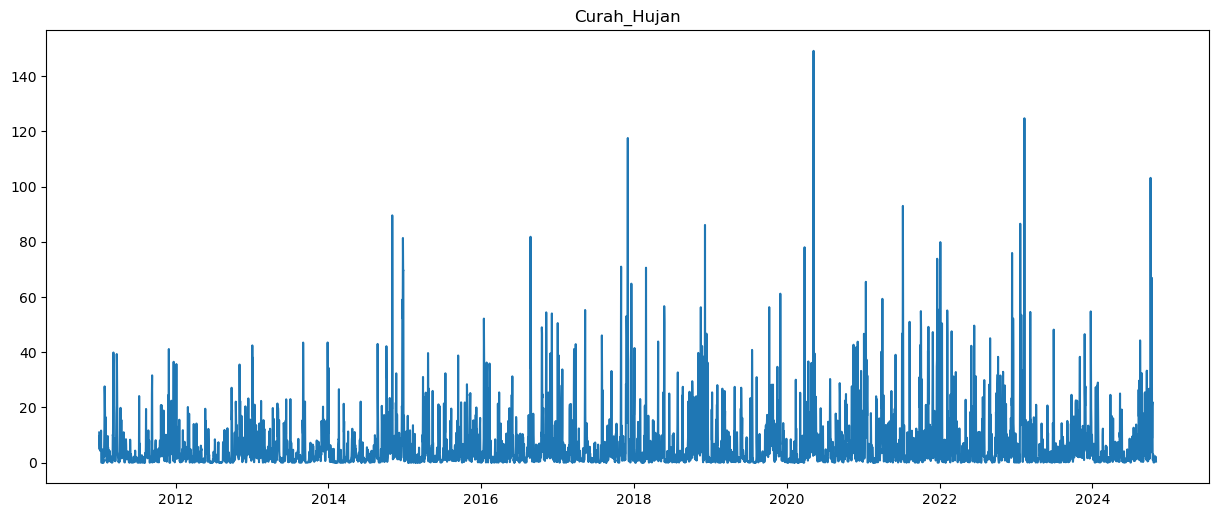

In [13]:
plt.figure(figsize=(15, 6), dpi=100)
plt.title('Curah_Hujan')
plt.plot(df['Curah_Hujan'])

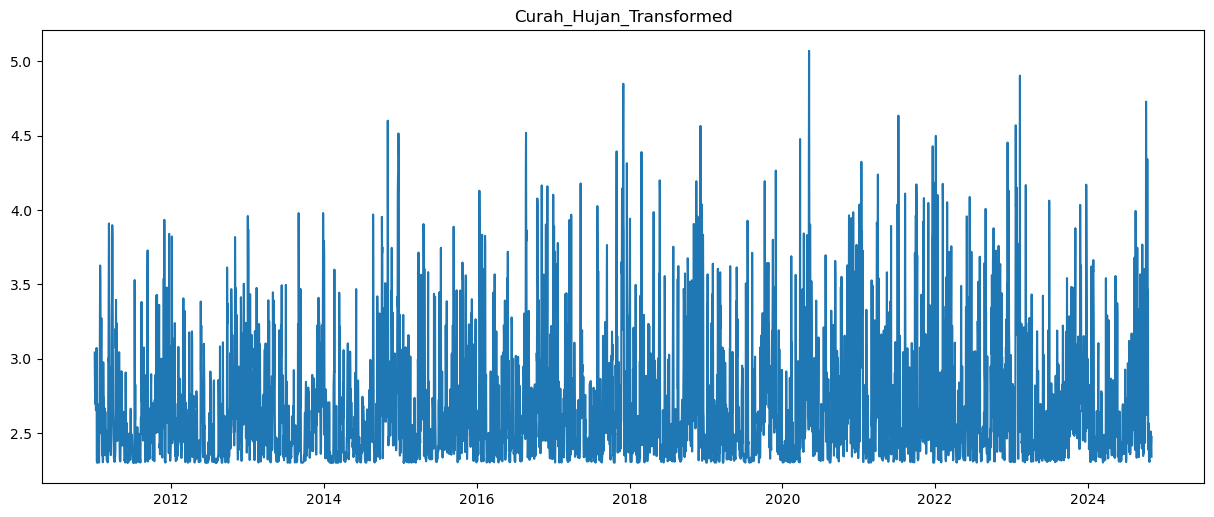

In [14]:
plt.figure(figsize=(15, 6), dpi=100)
plt.title('Curah_Hujan_Transformed')
plt.plot(df['Curah_Hujan_Transformed'])

In [15]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

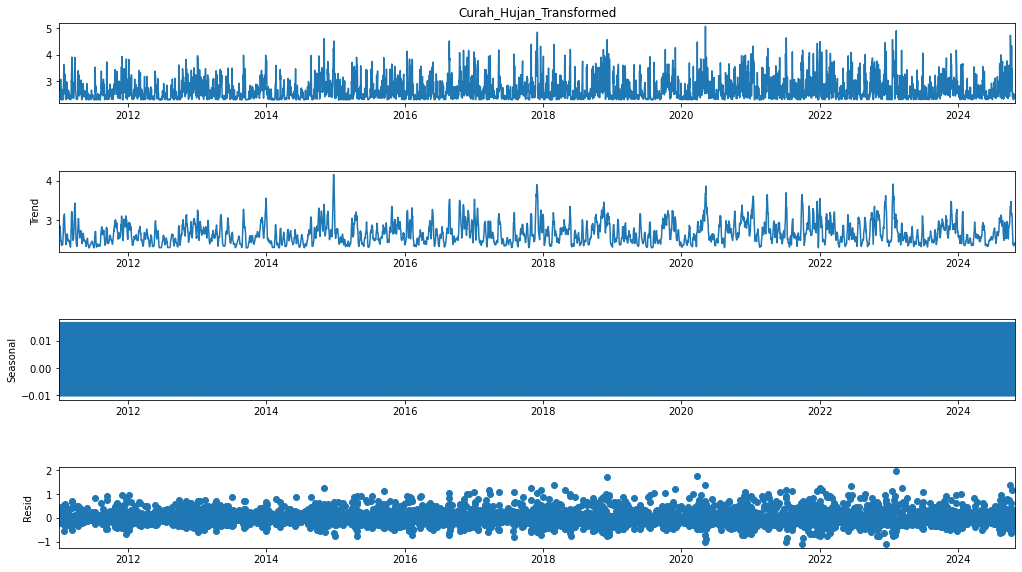

In [16]:
ch_decompose = seasonal_decompose(df['Curah_Hujan_Transformed'], model = "additive")
fig = ch_decompose.plot()
fig.set_size_inches(16,9)
plt.show()

In [8]:
# Tentukan proporsi pembagian
train_size = int(len(df) * 0.9)

# Membagi data
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [9]:
# Menampilkan baris dengan nilai di bawah 0
nilai_negatif = df[df['Curah_Hujan'] < 0]

print(nilai_negatif)

Empty DataFrame
Columns: [Suhu, Kelembaban, Curah_Hujan]
Index: []


In [10]:
train.tail()

,Suhu,Kelembaban,Curah_Hujan
Tanggal,,,
2023-06-09,28.22,76.00,1.18
2023-06-10,27.73,78.00,2.50
2023-06-11,28.70,71.50,0.31
2023-06-12,28.59,75.25,0.22
2023-06-13,28.79,72.69,0.14


In [11]:
test

,Suhu,Kelembaban,Curah_Hujan
Tanggal,,,
2023-06-14,28.99,71.06,0.22
2023-06-15,28.57,71.88,1.74
2023-06-16,28.45,74.19,3.56
2023-06-17,28.30,75.94,4.18
2023-06-18,28.25,72.75,0.81
...,...,...,...
2024-10-27,27.44,79.94,2.33
2024-10-28,27.52,79.69,1.27
2024-10-29,27.20,80.50,1.39


In [12]:
hwmodel=ExponentialSmoothing(train.Curah_Hujan,trend='add', seasonal='add', seasonal_periods=365, damped_trend=True).fit(optimized=True)
print(hwmodel.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:              Curah_Hujan   No. Observations:                 4547
Model:             ExponentialSmoothing   SSE                         409212.698
Optimized:                         True   AIC                          21200.442
Trend:                         Additive   BIC                          23576.665
Seasonal:                      Additive   AICC                         21266.928
Seasonal Periods:                   365   Date:                 Sun, 22 Dec 2024
Box-Cox:                          False   Time:                         15:13:25
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.3552285                alpha                 True
smoothing_trend       

In [13]:
test_pred=hwmodel.forecast(506)
# Menampilkan baris dengan nilai di bawah 0
nilai_negatif = np.sum(test_pred < 0)

print(nilai_negatif)

304


In [14]:
# Menggunakan clamping untuk mengganti nilai negatif menjadi nol
test_pred = np.clip(test_pred, 0, None)

<AxesSubplot:title={'center':'Curah_Hujan Spliting 90 : 10'}, xlabel='Tanggal'>

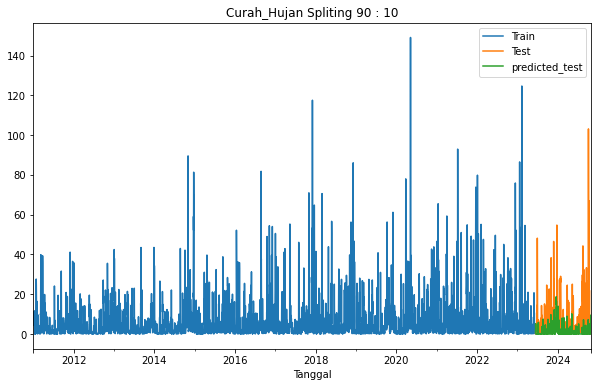

In [15]:
train['Curah_Hujan'].plot(legend=True, label='Train', figsize=(10,6))
test['Curah_Hujan'].plot(legend=True, label='Test')

plt.title('Curah_Hujan Spliting 90 : 10')
test_pred.plot(legend=True, label='predicted_test')

In [16]:
#Spliting 90 : 10
from sklearn.metrics import mean_squared_error
# Calculate errors
errors = abs(test['Curah_Hujan'] - test_pred)
mae = np.mean(np.abs(errors))
mse = mean_squared_error(test['Curah_Hujan'], test_pred)
rmse = np.sqrt(mse)

# Print results
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 5.63
MSE: 112.01
RMSE: 10.58


In [23]:
# Buat model Holt-Winters dengan parameter manual
hw_model = ExponentialSmoothing(
    df['Curah_Hujan'], 
    trend="add",            # Trend aditif
    seasonal="add",         # Seasonal aditif
    seasonal_periods=365     # Jumlah periode musiman (contoh: data bulanan)
)

# Fit model dengan parameter manual
fitted_model = hw_model.fit(
    smoothing_level= 0.3552285,  # alpha
    smoothing_slope=0.0062059,  # beta
    smoothing_seasonal=0.0844516,  # gamma
    optimized=False  # Jangan optimalkan, gunakan parameter manual
)

C:\Users\USER\AppData\Local\Temp\ipykernel_7820\1093952865.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = hw_model.fit(


In [24]:
# Hasil
print(fitted_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:              Curah_Hujan   No. Observations:                 5053
Model:             ExponentialSmoothing   SSE                         475062.569
Optimized:                        False   AIC                          23696.126
Trend:                         Additive   BIC                          26104.861
Seasonal:                      Additive   AICC                         23755.092
Seasonal Periods:                   365   Date:                 Sun, 22 Dec 2024
Box-Cox:                          False   Time:                         15:16:44
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.3552285                alpha                False
smoothing_trend       

In [25]:
# Prediksi ke depan
pred = fitted_model.forecast(steps=365)
print(pred)

2024-11-01     2.259000
2024-11-02    -0.040381
2024-11-03    -3.104293
2024-11-04    -3.811458
2024-11-05    -1.964822
                ...    
2025-10-27   -37.792695
2025-10-28   -33.303080
2025-10-29   -32.199980
2025-10-30   -24.476918
2025-10-31   -28.025417
Freq: D, Length: 365, dtype: float64


In [26]:
# Simpan hasil prediksi ke dalam DataFrame (jika belum dalam DataFrame)
pred_df = pd.DataFrame({'Date': pred.index, 'Curah Hujan': pred.values})

# Simpan ke file CSV
pred_df.to_csv('D:/cool/TA/data/HW curah hujan NASA.csv', index=False)

In [31]:
# Menampilkan baris dengan nilai di bawah 0
nilai_negatif = np.sum(pred < 0)

print(nilai_negatif)

357


In [35]:
# Menggunakan clamping untuk mengganti nilai negatif menjadi nol
pred = np.clip(pred, 0, None)

In [36]:
historical_data = df['Curah_Hujan']

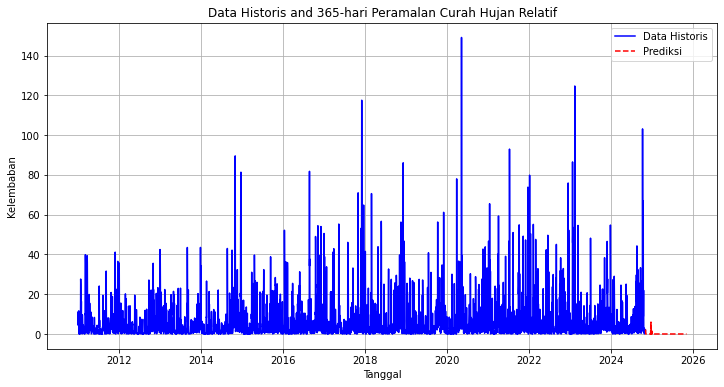

In [38]:
# Visualisasi
plt.figure(figsize=(12, 6))

# Plot data historis
plt.plot(historical_data.index, historical_data, label='Data Historis', color='blue')

# Plot prediksi
plt.plot(pred.index, pred.values, label='Prediksi', color='Red', linestyle='--')

# Tambahkan label dan judul
plt.xlabel('Tanggal')
plt.ylabel('Kelembaban')
plt.title('Data Historis and 365-hari Peramalan Curah Hujan Relatif')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()

In [65]:
hwmodel=ExponentialSmoothing(train.Curah_Hujan_Transformed,trend='add', seasonal='add', seasonal_periods=365, damped_trend=True).fit(optimized=True)
print(hwmodel.summary())

                         ExponentialSmoothing Model Results                        
Dep. Variable:     Curah_Hujan_Transformed   No. Observations:                 4042
Model:                ExponentialSmoothing   SSE                            459.547
Optimized:                            True   AIC                          -8048.337
Trend:                            Additive   BIC                          -5715.674
Seasonal:                         Additive   AICC                         -7972.700
Seasonal Periods:                      365   Date:                 Thu, 05 Dec 2024
Box-Cox:                             False   Time:                         13:12:58
Box-Cox Coeff.:                       None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.4830511                alpha                 

D:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [66]:
test_pred=hwmodel.forecast(1011)

In [67]:
test_pred

2022-01-25    2.829154
2022-01-26    2.670072
2022-01-27    2.716550
2022-01-28    2.575967
2022-01-29    2.704721
                ...   
2024-10-27    2.695239
2024-10-28    2.892593
2024-10-29    2.904888
2024-10-30    2.866720
2024-10-31    2.888351
Freq: D, Length: 1011, dtype: float64

In [68]:
# Menampilkan baris dengan nilai di bawah 0
nilai_negatif = np.sum(test_pred < 0)

print(nilai_negatif)

0


In [69]:
# Menggunakan clamping untuk mengganti nilai negatif menjadi nol
test_pred = np.clip(test_pred, 0, None)

<AxesSubplot:title={'center':'Curah_Hujan Spliting 80 : 20'}, xlabel='Tanggal'>

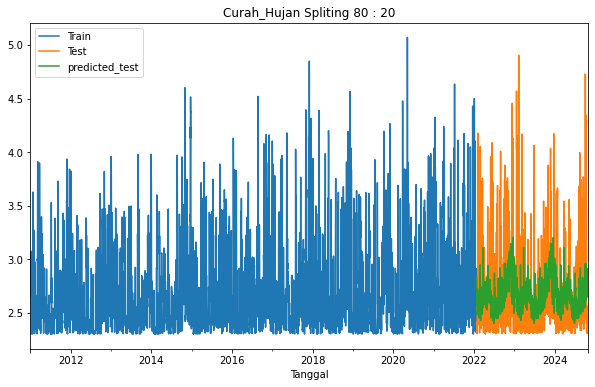

In [70]:
train['Curah_Hujan_Transformed'].plot(legend=True, label='Train', figsize=(10,6))
test['Curah_Hujan_Transformed'].plot(legend=True, label='Test')
plt.title('Curah_Hujan Spliting 80 : 20')
test_pred.plot(legend=True, label='predicted_test')

In [71]:
#Spliting data 80:20
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# Calculate errors
errors = abs(test['Curah_Hujan_Transformed'] - test_pred)
mae = np.mean(np.abs(errors))
mse = mean_squared_error(test['Curah_Hujan_Transformed'], test_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / test['Curah_Hujan_Transformed'])) * 100
MAPE = mean_absolute_percentage_error(test['Curah_Hujan_Transformed'], test_pred)

# Print results
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print("(MAPE):", MAPE)

MAE: 0.32
MSE: 0.19
RMSE: 0.43
MAPE: 11.09%
(MAPE): 0.11094549872515276


In [328]:
import numpy as np
import pandas as pd

# Asumsi test_pred sudah dalam bentuk DataFrame atau Series
# Jika test_pred adalah Series, konversi ke DataFrame terlebih dahulu
test_pred_df = test_pred.to_frame(name="Prediksi")

# Inverse scaling pada kolom "Prediksi"
test_pred_df[["pred_asli"]] = scaler.inverse_transform(test_pred_df[["Prediksi"]])

# Cetak hasil forecast dengan tanggal
print(test_pred_df[["pred_asli"]])

             pred_asli
2020-09-07  563.428098
2020-09-08  636.514589
2020-09-09  546.058825
2020-09-10  544.647691
2020-09-11  589.889324
...                ...
2024-10-27  583.280041
2024-10-28  595.600668
2024-10-29  567.581292
2024-10-30  605.093287
2024-10-31  631.886570

[1516 rows x 1 columns]


In [48]:
pred_asli

array([[26.27335909],
       [14.73970874],
       [ 4.37612215],
       [16.75274719],
       [49.78928684],
       [28.95576421],
       [17.66733739],
       [ 7.04394455],
       [ 5.0903889 ],
       [ 5.32162507],
       [ 9.63293185],
       [ 2.88949088],
       [ 2.85108505],
       [ 2.78754509],
       [ 3.80393713],
       [ 4.02530252],
       [ 6.22662396],
       [ 8.06305278],
       [10.93464741],
       [ 9.39104034],
       [ 5.82741431],
       [14.51374063],
       [ 8.50993274],
       [ 3.90134603],
       [10.5179801 ],
       [ 8.95457557],
       [ 9.19596382],
       [13.66239041],
       [18.13869945],
       [ 7.91014036],
       [ 3.87660119],
       [ 3.34297512],
       [ 3.79933033],
       [ 2.79563115],
       [ 2.78708432],
       [ 8.66344375],
       [28.1998501 ],
       [13.02128143],
       [ 5.90277978],
       [ 5.46920048],
       [ 6.34546878],
       [ 3.66169903],
       [ 5.68807235],
       [ 4.72947097],
       [ 5.28076192],
       [ 6

In [68]:
# Tentukan tanggal awal dan buat rentang tanggal
start_date = '2023-07-05'  # Sesuaikan tanggal mulai sesuai kebutuhan
date_range = pd.date_range(start=start_date, periods=len(pred_asli), freq='D')

# Konversi array menjadi Series dengan tanggal sebagai indeks
pred_asli_series = pd.Series(pred_asli.flatten(), index=date_range, name='pred_asli')

# Tampilkan hasil Series
print(pred_asli_series)

2023-07-05    26.273359
2023-07-06    14.739709
2023-07-07     4.376122
2023-07-08    16.752747
2023-07-09    49.789287
                ...    
2024-07-27     3.901346
2024-07-28    10.517980
2024-07-29     8.954576
2024-07-30     9.195964
2024-07-31    13.662390
Freq: D, Name: pred_asli, Length: 393, dtype: float64


In [59]:
# Anti-transformasi Log
pred_asli = np.exp(test_pred) - 10
pred_asli

2023-06-14    0.829638
2023-06-15    2.034375
2023-06-16    0.227953
2023-06-17   -0.003073
2023-06-18   -0.123651
                ...   
2024-10-27    2.001963
2024-10-28    5.070285
2024-10-29    5.546134
2024-10-30    5.394630
2024-10-31    4.122624
Freq: D, Length: 506, dtype: float64

<AxesSubplot:xlabel='Tanggal'>

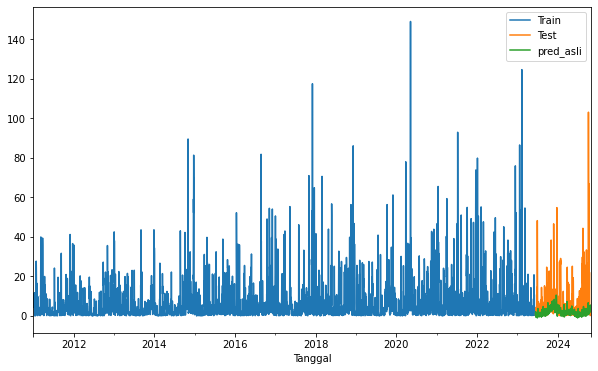

In [60]:
train['Curah_Hujan'].plot(legend=True, label='Train', figsize=(10,6))
test['Curah_Hujan'].plot(legend=True, label='Test')

pred_asli.plot(legend=True, label='pred_asli')

In [268]:
# Anti-transformasi Log
pred_asli = np.expm1(test_pred) - 10
pred_asli

2023-06-14    1.216781
2023-06-15    2.849416
2023-06-16    0.963345
2023-06-17    3.480262
2023-06-18    2.608959
                ...   
2024-10-27    4.313979
2024-10-28    3.380028
2024-10-29    5.108220
2024-10-30    4.911235
2024-10-31    8.436160
Freq: D, Length: 506, dtype: float64

In [931]:
# Anti-transformasi Log
pred_asli = test_pred**2
pred_asli

2023-07-05     8.239604
2023-07-06     3.164824
2023-07-07     0.058130
2023-07-08     5.223277
2023-07-09    20.449370
                ...    
2024-07-27     0.031830
2024-07-28     2.010722
2024-07-29     2.994543
2024-07-30     2.656051
2024-07-31     6.431301
Freq: D, Length: 393, dtype: float64

In [132]:
pred_asli = test_pred * (df['Curah_Hujan'].max() - df['Curah_Hujan'].min()) + df['Curah_Hujan'].min()
pred_asli

2023-07-05    26.252818
2023-07-06    14.723263
2023-07-07     4.353106
2023-07-08    16.720907
2023-07-09    49.761170
                ...    
2024-07-27     3.811984
2024-07-28    10.425815
2024-07-29     8.857970
2024-07-30     9.091755
2024-07-31    13.553410
Freq: D, Length: 393, dtype: float64

In [913]:
test['Curah_Hujan']

Tanggal
2023-07-05     0.13
2023-07-06     0.16
2023-07-07     0.75
2023-07-08     1.45
2023-07-09     2.64
              ...  
2024-07-27     7.33
2024-07-28    13.82
2024-07-29     5.29
2024-07-30     1.23
2024-07-31     3.19
Freq: D, Name: Curah_Hujan, Length: 393, dtype: float64

In [43]:
# Menampilkan baris dengan nilai di bawah 0
nilai_negatif = np.sum(pred_asli < 0)

print(nilai_negatif)

3


In [44]:
# Menggunakan clamping untuk mengganti nilai negatif menjadi nol
pred_asli = np.clip(pred_asli, 0, None)

<AxesSubplot:xlabel='Tanggal'>

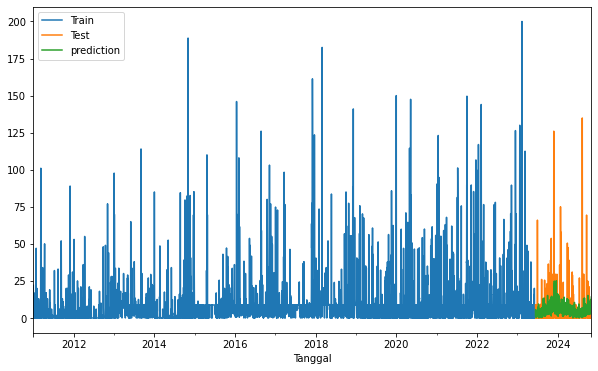

In [45]:
train['Curah_Hujan'].plot(legend=True, label='Train', figsize=(10,6))
test['Curah_Hujan'].plot(legend=True, label='Test')

pred_asli.plot(legend=True, label='prediction')

In [294]:
# Calculate errors
errors = abs(test['Curah_Hujan'] - pred_asli)
mae = np.mean(np.abs(errors))
mse = mean_squared_error(test['Curah_Hujan'], pred_asli)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / test['Curah_Hujan'])) * 100
MAPE = mean_absolute_percentage_error(test['Curah_Hujan'], pred_asli)

# Print results
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print("(MAPE):", MAPE)

MAE: 3.89
MSE: 35.03
RMSE: 5.92
MAPE: 162.89%
(MAPE): 1.628925483023964


In [935]:
x = 2
p = np.sqrt(x)

In [937]:
y = p**2
y

2.0000000000000004

In [588]:
import matplotlib.pyplot as plt
from scipy import stats

# Uji Shapiro-Wilk
stat, p_value = stats.shapiro(residual)
print('Statistik Shapiro-Wilk:', stat)
print('P-value:', p_value)

# Interpretasi
alpha = 0.05
if p_value > alpha:
    print("Tidak ada cukup bukti untuk menolak hipotesis nol (data terdistribusi normal)")
else:
    print("Ada cukup bukti untuk menolak hipotesis nol (data tidak terdistribusi normal)")

Statistik Shapiro-Wilk: 0.9171596765518188
P-value: 6.968562418730936e-14
Ada cukup bukti untuk menolak hipotesis nol (data tidak terdistribusi normal)


In [270]:
x = 2

In [271]:
p = np.log (x + 500)
p

6.218600119691729

In [273]:
y = np.exp(p) - 500
y

1.9999999999998295

In [155]:
# Calculate errors
errors = abs(test['Curah_Hujan_Normalized'] - test_pred)
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / test['Curah_Hujan_Normalized'])) * 100

# Print results
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

KeyError: 'Curah_Hujan_Normalized'

In [58]:
final_model=ExponentialSmoothing(df.Scaled_Data,trend='add', seasonal='add', seasonal_periods=365).fit()

In [59]:
pred=final_model.forecast(365)

In [60]:
pred

2024-08-01    0.047315
2024-08-02   -0.411923
2024-08-03   -0.777368
2024-08-04   -0.818084
2024-08-05   -0.720217
                ...   
2025-07-27   -0.838153
2025-07-28   -0.118034
2025-07-29   -0.326559
2025-07-30   -0.416549
2025-07-31   -0.103021
Freq: D, Length: 365, dtype: float64

In [63]:
# Mengembalikan hasil ke skala asli
forecast_original = scaler.inverse_transform(pred.values.reshape(-1, 1))

# Menampilkan hasil prediksi
print("\nHasil prediksi 10 langkah ke depan:")
print(forecast_original.flatten())


Hasil prediksi 10 langkah ke depan:
[ 3.26323820e+00 -1.16754051e-01 -2.80642605e+00 -3.10609514e+00
 -2.38579467e+00  1.21771525e+00 -1.41868146e+00  1.63151576e+00
  3.10518791e+00  3.32546694e+00  1.85821228e-01  1.36941299e+00
  1.29947800e+00 -2.60048413e+00 -1.22041196e+00 -2.00367206e+00
 -1.80358727e+00 -9.53497152e-01 -2.19333203e+00  2.82686549e+00
  5.36770365e-02 -9.79460445e-01 -1.92595895e+00  4.99760789e+00
 -1.22183274e-01 -6.85414410e-01 -1.86530068e+00  1.06154294e+00
  5.92501520e+00  7.35090723e-01  4.75182665e+00 -9.08171122e-01
  2.84851252e+00  1.53528297e+00 -1.31126212e+00 -1.72115577e+00
 -1.08403783e-03 -1.17753943e+00 -2.97326776e-01 -2.48723435e+00
  6.53056656e-01 -2.20344735e+00 -2.18660858e+00 -2.54639353e+00
 -1.14607833e+00 -9.72615615e-01 -2.97247814e+00  1.03758710e+00
  3.04095181e+00  1.49437292e+00  8.45028288e-02 -1.93202328e+00
  5.77815434e+00  2.36506314e+00  3.91816268e-01  5.91856849e+00
  1.12186683e+01  7.70543595e+00  9.49572081e+00  7.7

<AxesSubplot:xlabel='Tanggal'>

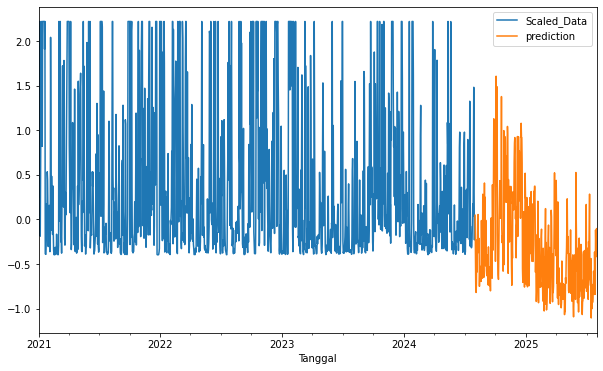

In [65]:
df['Scaled_Data'].plot(legend=True, label='Scaled_Data', figsize=(10,6))
pred.plot(legend=True, label='prediction')

In [ ]:
test_kl.plot(legend=True, label='Test')
test_kl.plot(legend=True, label='predicted_test')

In [56]:
model = HWES(train_kl, seasonal_periods = 365, trend = 'add', seasonal = "add")
fitted = model.fit()
print(fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Kelembaban   No. Observations:                 1045
Model:             ExponentialSmoothing   SSE                           8028.560
Optimized:                         True   AIC                           2868.743
Trend:                         Additive   BIC                           4695.947
Seasonal:                      Additive   AICC                          3278.883
Seasonal Periods:                   365   Date:                 Tue, 13 Aug 2024
Box-Cox:                          False   Time:                         20:36:02
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.5524601                alpha                 True
smoothing_trend       

In [57]:
model = HWES(train_kl, seasonal_periods = 365, trend = 'add', seasonal = "mul")
fitted = model.fit(optimized=True, use_brute=True)
print(fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Kelembaban   No. Observations:                 1045
Model:             ExponentialSmoothing   SSE                          10212.190
Optimized:                         True   AIC                           3120.146
Trend:                         Additive   BIC                           4947.350
Seasonal:                Multiplicative   AICC                          3530.285
Seasonal Periods:                   365   Date:                 Tue, 13 Aug 2024
Box-Cox:                          False   Time:                         20:36:15
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.5296300                alpha                 True
smoothing_trend       

D:\anaconda2\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [58]:
forecast = fitted.forecast(steps=12)

InvalidIndexError: (slice(None, None, None), None)

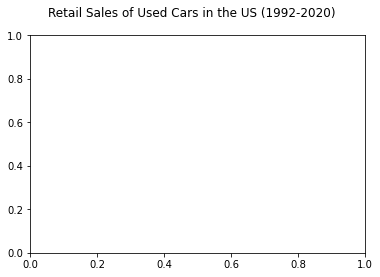

In [60]:
fig = plt.figure()
fig.suptitle('Retail Sales of Used Cars in the US (1992-2020)')
past, = plt.plot(train_kl.index, train_kl, 'b.-', label='Sales History')
future, = plt.plot(test_kl.index, test_kl, 'r.-', label='Actual Sales')
predicted_future, = plt.plot(test_kl.index, forecast, 'g.-', label='Sales Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

InvalidIndexError: (slice(None, None, None), None)

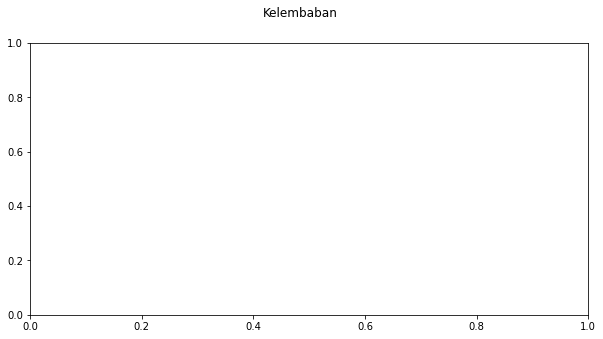

In [63]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Kelembaban') 
past, = plt.plot(train_kl.index, train_kl, 'b.-', label='train')
future, = plt.plot(test_kl.index, test_kl, 'r.-', label='test')
predicted_future, = plt.plot(test_kl.index, forecast, 'g.-', label='Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

NameError: name 'prediction_kl' is not defined

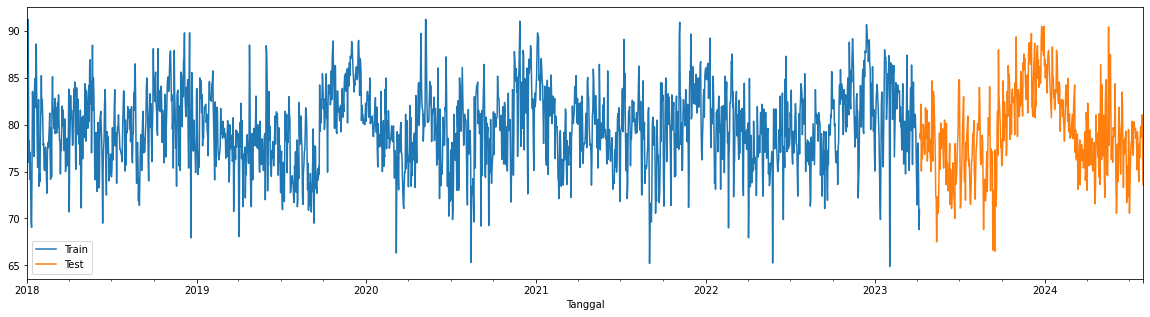

In [23]:
train_kl['Kelembaban'].plot(legend=True, label='Train', figsize=(20,5))
test_kl['Kelembaban'].plot(legend=True, label="Test")
prediction_kl.plot(legend=True,label='Prediction')
plt.title("Model Result",size=30)
plt.show()

In [ ]:
df=df.groupby('Tanggal').sum()

In [14]:
hwmodel_kl=ExponentialSmoothing(train.Kelembaban, trend='add', seasonal='mul', seasonal_periods=4).fit()

D:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [15]:
test_pred=hwmodel_kl.forecast(300)

<AxesSubplot:xlabel='Tanggal'>

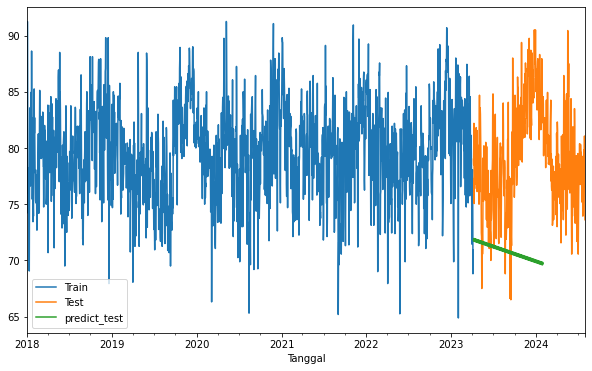

In [16]:
train['Kelembaban'].plot(legend=True, label='Train', figsize=(10,6))
test['Kelembaban'].plot(legend=True, label='Test')
test_pred.plot(legend=True, label='predict_test')

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [43]:
np.sqrt(mean_squared_error(test,test_pred))

ValueError: Found input variables with inconsistent numbers of samples: [481, 300]

In [83]:
ch = df.drop(columns=['Kelembaban','Suhu'])

<AxesSubplot:xlabel='Tanggal'>

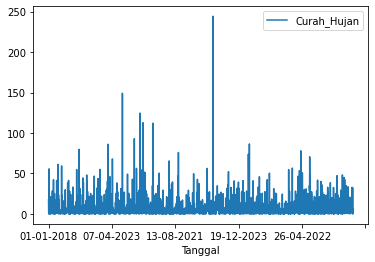

In [84]:
ch.plot()

In [85]:
# Tentukan proporsi pembagian
train_size = int(len(ch) * 0.8)

# Membagi data
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [86]:
train.tail()

,Curah_Hujan,Kelembaban,Suhu
Tanggal,,,
25-04-2018,14.80,75.75,30.26
25-04-2019,11.53,88.50,27.99
25-04-2020,5.29,81.25,29.31
25-04-2021,0.14,80.06,29.19
25-04-2022,7.14,77.75,29.91


In [99]:
hwmodel=ExponentialSmoothing(train.Curah_Hujan, trend='add', seasonal='add', seasonal_periods=4).fit()

D:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '13-01-2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
D:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '13-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
D:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '13-01-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
D:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '13-01-2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
D:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557

In [92]:
test_pred=hwmodel.forecast(5)

NameError: name 'hwmodel' is not defined

In [93]:
decompose_result = seasonal_decompose(ch['Curah_Hujan'],model='multiplicative')

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [59]:
ch = ch.set_index('Tanggal')

Text(0, 0.5, 'Curah Hujan')

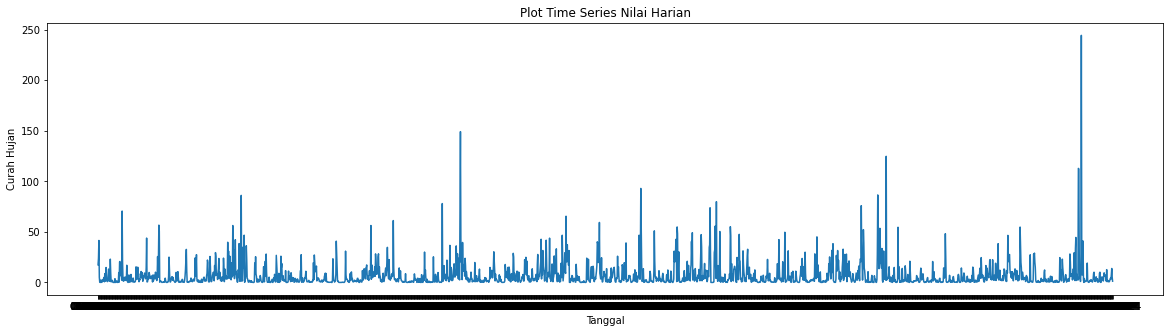

In [60]:
plt.figure(figsize=(20, 5))
plt.plot(ch.index,ch['Curah Hujan'])

# Menambahkan judul dan label
plt.title('Plot Time Series Nilai Harian')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan')

In [65]:
ch.sort_index(inplace = TRUE)

NameError: name 'TRUE' is not defined

In [47]:
from forecast import plot_components_x13
plot_components_x13(ch)
plt.show()

ModuleNotFoundError: No module named 'forecast'

In [63]:
decompose_result = seasonal_decompose(ch['Curah Hujan'], model = 'aditive')
decompose_result.plot()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

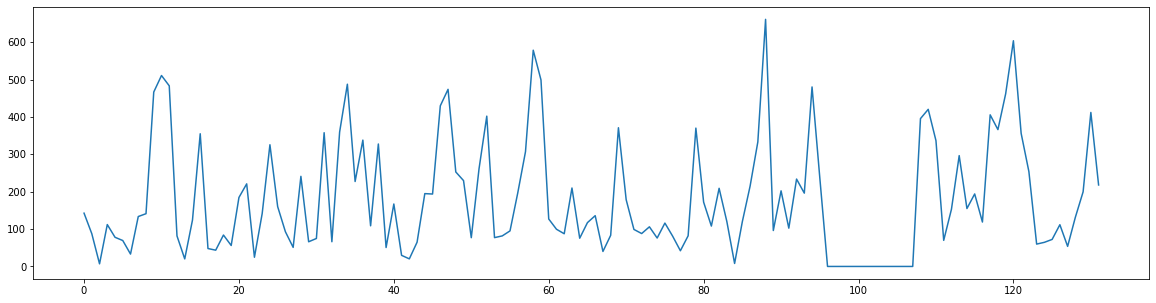

In [22]:
ch = ch['Curah Hujan'].plot(figsize=(20,5))
plt.show()

In [23]:
df_decompose = seasonal_decompose(df['SST'],model = "additive")
fig = df_decompose.plot()
fig.set_size_inches(16,9)
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

In [8]:
size = int(len(df)*0.8)
train_df = df[:size]
test_df = df[size:]

In [9]:
train_df.tail()

,SST
Tahun,
2010-08-01,880.24
2010-09-01,860.53
2010-10-01,896.96
2010-11-01,882.95
2010-12-01,919.93


NameError: name 'predictions_df' is not defined

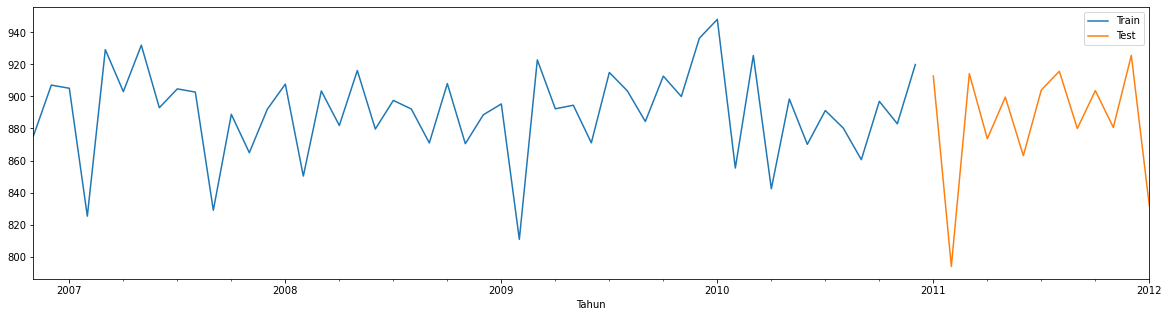

In [12]:
train_df['SST'].plot(legend=True, label="Train", figsize=(20,5))
test_df['SST'].plot(legend=True, label="Test")
predictions_df.plot(legend=True, label="Prediction")
plt.title("Model Result", size=20)
plt.show()

In [20]:
fitted_model = ExponentialSmoothing(train_df['SST'], trend='add', seasonal='add', seasonal_periods=12)
predictions_df = fitted_model.forecast(60)

AttributeError: 'ExponentialSmoothing' object has no attribute 'forecast'